In [306]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

from numpy import exp as exp
from tqdm import tqdm

import matplotlib as mpl
from matplotlib import cm

max_cpus=19
qutip.settings.num_cpus = max_cpus

def catiness(rho,phase=0):

    cutoff = rho.shape[0]
    a_red = destroy(cutoff)
    a2 = expect(rho,a_red*a_red)
    alpha = np.sqrt(a2)
    cat = ket2dm((coherent(cutoff,alpha) +np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat_opposite = ket2dm((coherent(cutoff,alpha) -np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat = cat/np.trace(cat)
    cat_opposite = cat_opposite/np.trace(cat_opposite)
    overlap = abs(coherent(cutoff,alpha).overlap(coherent(cutoff,-alpha)))**2
    fid1=fidelity(cat,rho)
    rho2=(a_red*rho*a_red.dag())
    rho2 = rho2/np.trace(rho2)
    fid2 = fidelity(cat_opposite,rho2)


    return fid1*fid2*(1-overlap)

In [312]:
cutoff1 = 20
cutoff2 = 2

s = tensor(destroy(cutoff1), qeye(cutoff2))
b = tensor(qeye(cutoff1), destroy(cutoff2))

In [310]:
Deltac =10000
r=1

a = np.cosh(r)*s - np.sinh(r)*s.dag()
g = 1
kappa = 300


delta2 =14000# Detuning with respect to Delta_s
delta1 = 23000 # Detuning with respect to zero 


Omega2p = Deltac*(exp(4*r)-1)/(exp(4*r)+1)
Deltas=Deltac*np.sqrt(1-(Omega2p/Deltac)**2)

alpha1 = 1.5
alpha2 = 0.25

alpha0 = np.sqrt(Omega2p/4.)

kappa2 = 4*(2*g*alpha1*np.cosh(r)**2)**2/kappa
G = 2*alpha1*alpha2*g*np.cosh(r)**2
na_expected = G/(kappa2)


four_drives = True

if four_drives==True:
    alpha_list = [alpha1,alpha2,alpha0,alpha0]
    nalpha = len(alpha_list)
    Delta_list = [Deltas-delta2, Deltas + delta2,-delta1,delta1]
    H0 = Deltac*a.dag()*a + (Deltas+delta2)*b.dag()*b + g*(a.dag()*a.dag()*b*b + a*a*b.dag()*b.dag())


else:
    alpha_list = [alpha1,alpha2]
    Delta_list = [Deltas-delta2, Deltas + delta2,-delta1,delta1]
    nalpha = len(alpha_list)
    H0 = Deltac*a.dag()*a + 2*g*alpha0**2*(a.dag()*a.dag()+a*a)+ (Deltas+delta2)*b.dag()*b + g*(a.dag()*a.dag()*b*b + a*a*b.dag()*b.dag())

In [311]:
alpha0**2

2.4100689501895416

In [287]:
-delta2+delta1-Deltas

6341.977711659204

In [273]:
condition1=Deltas/(2*alpha1*alpha2*g*np.cosh(r)**2)
condition1bis= alpha0**2/(alpha1*alpha2*exp(2*r))

print("Condition I: "+str(condition1))
print("Condition I (alt): "+str(condition1bis))

Condition I: 1190.721237910755
Condition I (alt): 695.8237098531574


# Approach 1: Cython

We write each time-dependent term in the Hamiltonian in the expansion

${a^\dagger}^2 \left(\sum_i \alpha_i e^{i\Delta_i t} + b\right)^2 +\text{H.c.}= {a^\dagger}^2 \left(\sum_{i,j} \alpha_i \alpha_j e^{i(\Delta_i +\Delta_j)t} + 2b\sum_i \alpha_i e^{i\Delta_i t} + b^2 \right)+\text{H.c.}$

(Note that the time-independent term ${a^\dagger}^2 b^2$ is already included in $H_0$ above)

In [274]:
def H_exp_string(Delta_i):
    return 'exp(1.j * t*('+str(Delta_i)+') )'

def H_list(alpha_list,Delta_list,H0):
  H= [H0]
  for i, alpha_i in enumerate(alpha_list):
    # alpha_i b terms
    H.append([
              2*g*alpha_i*
              b*a.dag()*a.dag(),
              H_exp_string(-Delta_list[i])])
    H.append([
              2*np.conj(g*alpha_i)
              *b.dag()*a*a,
              H_exp_string(Delta_list[i])])
    
    # alpha_i^2 terms
    H.append([
              g*(alpha_i**2)*a.dag()*a.dag(),
              H_exp_string(-2*Delta_list[i])
    ])
    H.append([
              np.conj(g*alpha_i**2)*a*a,
              H_exp_string(2*Delta_list[i])
    ])
    for j in range(i+1,nalpha):
      alpha_j= alpha_list[j]
      H.append([
                2*g*alpha_i*alpha_j*a.dag()*a.dag(),
                H_exp_string(-Delta_list[i]-Delta_list[j])])
      H.append([
                2*np.conj(g*alpha_i*alpha_j)*a*a,
                H_exp_string(Delta_list[i]+Delta_list[j])])

  return H
  

In [275]:
H = H_list(alpha_list,Delta_list,H0)
len(H)

29

## Adding terms by hand (for testing

In [276]:
'''# Self-counter rotating for the first two-photon drive  : THESE DESTROY THE DYNAMICS
H.append([
          g*alpha0**2*a.dag()*a.dag(),
          H_exp_string(-2*delta1)])

H.append([
          np.conj(g*alpha0**2)*a*a,
          H_exp_string(2*delta1)])'''

          # Interference terms between first and second drive s
'''H.append([
    2*g*alpha0*alpha1*a.dag()*a.dag(),
    H_exp_string(-delta1-(Deltas-delta2))])

H.append([
    2*g*alpha0*alpha2*a.dag()*a.dag(),
    H_exp_string(-delta1-(Deltas+delta2))])

H.append([
    2*np.conj(g*alpha0*alpha1)*a*a,
    H_exp_string(delta1+(Deltas-delta2))])

H.append([
    2*np.conj(g*alpha0*alpha2)*a*a,
    H_exp_string(delta1+(Deltas+delta2))])'''


'''# Interference terms between first and second drive s



H.append([
    2*g*alpha0*alpha1*a.dag()*a.dag(),
    H_exp_string(delta1-(Deltas-delta2))])

H.append([
    2*g*alpha0*alpha2*a.dag()*a.dag(),
    H_exp_string(delta1-(Deltas+delta2))])

H.append([
    2*np.conj(g*alpha0*alpha1)*a*a,
    H_exp_string(-delta1+(Deltas-delta2))])

H.append([
    2*np.conj(g*alpha0*alpha2)*a*a,
    H_exp_string(-delta1+(Deltas+delta2))])'''


'# Interference terms between first and second drive s\n\n\n\nH.append([\n    2*g*alpha0*alpha1*a.dag()*a.dag(),\n    H_exp_string(delta1-(Deltas-delta2))])\n\nH.append([\n    2*g*alpha0*alpha2*a.dag()*a.dag(),\n    H_exp_string(delta1-(Deltas+delta2))])\n\nH.append([\n    2*np.conj(g*alpha0*alpha1)*a*a,\n    H_exp_string(-delta1+(Deltas-delta2))])\n\nH.append([\n    2*np.conj(g*alpha0*alpha2)*a*a,\n    H_exp_string(-delta1+(Deltas+delta2))])'

## Single simulation

In [277]:
psi0 = tensor(basis(cutoff1, 0), basis(cutoff2, 0))
tfin = 2
tlist=np.linspace(0,tfin,100)

c_ops = [np.sqrt(kappa)*b]

options = Options()
options.store_final_state = True
options.nsteps = 100000
options.num_cpus=1

In [278]:
sol = mesolve(H, psi0, tlist, c_ops, [s.dag() * s],progress_bar=True, options=options)

10.0%. Run time: 604.49s. Est. time left: 00:01:30:40


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

In [263]:
# Colect results 
rho_ss=sol.final_state
ns_time = sol.expect[0]

n0 = expect(s.dag()*s,psi0)
ns_time_anal = n0/(1+2*n0**2*kappa2*tlist)

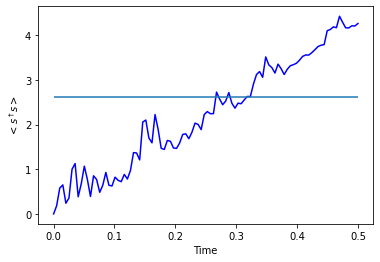

In [264]:
plt.plot(tlist, ns_time,'b')
#plt.plot(tlist, ns_time_anal,'--b')
#plt.plot(tlist, 2*exp(-6*kappa2*tlist),'--r')
plt.xlabel("Time")
plt.ylabel("$<s^\dagger s> $")
plt.hlines(na_expected,xmin=0,xmax=tfin)

plt.show()

In [265]:
rho_sq = rho_ss.ptrace(0)

xvec = np.linspace(-5,5,100)
wigner_ss = wigner(rho_sq,xvec,xvec)

/home/carlos/anaconda3/envs/QutipEnv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


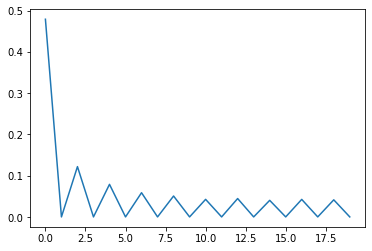

In [266]:
plt.plot(np.diag(rho_sq))
plt.show()

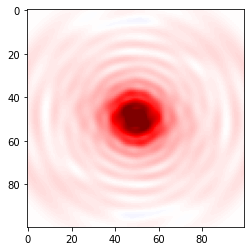

In [267]:
#wmap = wigner_cmap(wigner_ss)  # Generate Wigner colormap
nrm = mpl.colors.Normalize(-0.1, 0.1)
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

axes.imshow(wigner_ss, cmap='seismic', norm=nrm)
plt.show()

# Loop in frequencies

In [225]:
# I define a modified H in which the only time-dependent terms will be those dependent on db
def H_list_mod(alpha_list,Delta_list,H0):
  H= [H0]
  for i, alpha_i in enumerate(alpha_list):
    # alpha_i b terms
    H.append([
              2*g*alpha_i*
              b*a.dag()*a.dag(),
              H_exp_string(-Delta_list[i])])
    H.append([
              2*np.conj(g*alpha_i)
              *b.dag()*a*a,
              H_exp_string(Delta_list[i])])
    
    for j in range(i+1,nalpha):
      alpha_j= alpha_list[j]
      H.append([
                2*g*alpha_i*alpha_j*a.dag()*a.dag(),
                H_exp_string(-Delta_list[i]-Delta_list[j])])
      H.append([
                2*np.conj(g*alpha_i*alpha_j)*a*a,
                H_exp_string(Delta_list[i]+Delta_list[j])])

  return H

In [226]:
# Example
Hexample = H_list_mod(alpha_list,[Deltas-delta2, Deltas + delta2],H0)

[HH[1] for HH in Hexample[1:]]

IndexError: list index out of range

In [246]:
shift = 10.
Delta0min = Deltas-shift; Delta0max = Deltas + shift; nDelta0 = 17

Delta0grid = np.linspace(Delta0min,Delta0max,nDelta0)


In [247]:
def meSolveDelta(Delta0):
    psi0 = tensor(basis(cutoff1, 0), basis(cutoff2, 0))
    tfin = 0.1
    tlist=np.linspace(0,tfin,100)
    c_ops = [np.sqrt(kappa)*b]

    options = Options()
    options.store_final_state = True
    options.nsteps = 100000
    options.num_cpus=1
    if four_drives==True:
        Delta_list_sel = [Delta0-delta2, Delta0 + delta2,-delta1,delta1]
    else:
        Delta_list_sel = [Delta0-delta2, Delta0 + delta2]
    H = H_list(alpha_list,Delta_list_sel,H0)
    return mesolve(H, psi0, tlist, c_ops, [s.dag() * s], options=options)

In [248]:
sol_list=parallel_map(meSolveDelta,Delta0grid)

In [254]:
rho_sq_list = [sol.final_state.ptrace(0) for sol in sol_list]
catiness_list = np.array([catiness(rho_sq) for rho_sq in rho_sq_list])
wigner_list = [wigner(rho_sq,xvec,xvec) for rho_sq in rho_sq_list]
nss_list = [expect(s.dag()*s,sol.final_state) for sol in sol_list]
nat_list = np.array([sol.expect[0] for sol in sol_list])

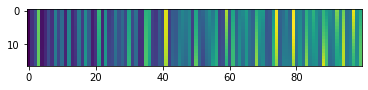

In [255]:
plt.imshow(nat_list)
plt.show()

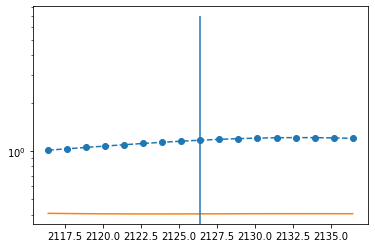

In [257]:
plt.plot(Delta0grid,nss_list,'o--')

plt.plot(Delta0grid,1-catiness_list)
plt.vlines(x=Deltas,ymin=0,ymax=7)
plt.yscale('log')
plt.show()

/home/carlos/anaconda3/envs/QutipEnv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


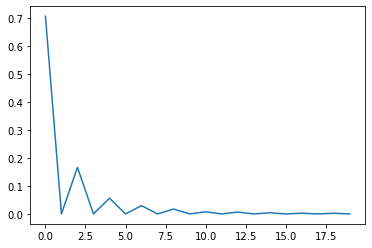

In [258]:
idx=8
plt.plot(np.diag(rho_sq_list[idx]))
plt.show()

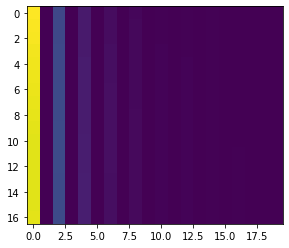

In [259]:
diagonals=np.array([np.diag(rho) for rho in rho_sq_list])

plt.imshow(np.abs(diagonals))
plt.show()

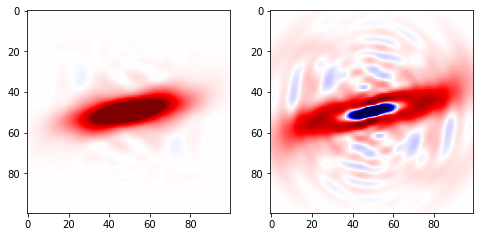

In [260]:
wig = wigner(rho_sq_list[idx],xvec,xvec)
sred = destroy(cutoff1)
wig2 = wigner(((sred)*(rho_sq_list[idx])*sred.dag()).unit(),xvec,xvec)
nrm = mpl.colors.Normalize(-0.1, 0.1)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

axes[0].imshow(wig, cmap='seismic', norm=nrm)
axes[1].imshow(wig2, cmap='seismic', norm=nrm)
plt.show()

# Read cluster data: Simulation 1

In [ ]:
Deltac = 1000
r=1
g = 1
kappa = 300


delta2 = 10000 # Detuning with respect to Delta_s

Omega2p = Deltac*(exp(4*r)-1)/(exp(4*r)+1)
Deltas=Deltac*np.sqrt(1-(Omega2p/Deltac)**2)

alpha1 = 1.5
alpha2 = 0.25
#alpha2 = 0.4
alpha0 = np.sqrt(Omega2p/4.)

alpha_list = [alpha1,alpha2]
shift = 0.
Delta_list = [Deltas-shift-delta2, Deltas-shift + delta2]

nalpha = len(alpha_list)
kappa2 = 4*(2*g*alpha1*np.cosh(r)**2)**2/kappa
G = 2*alpha1*alpha2*g*np.cosh(r)**2
na_expected = G/(kappa2)

na_expected, 1/kappa2, kappa2

print("kappa: "+str(kappa)+", Delta_s: "+str(Deltas))

In [ ]:
tfin = 2
#cutoff1=20
cutoff1=20
cutoff2 = 2
tlist=np.linspace(0,tfin,100)
a_red = destroy(cutoff1)
s = tensor(destroy(cutoff1), qeye(cutoff2))
shift = 10.
Delta0min = Deltas-shift; Delta0max = Deltas + shift; nDelta0 = 101
Delta0grid = np.linspace(Delta0min,Delta0max,nDelta0)

sol_list = [qload('data/sim1/sc-stabi-2drives-solution-idx-'+str(int(idx))+'.qu') for idx in range(nDelta0)]


In [ ]:
def catiness(rho,phase=0):

    cutoff = rho.shape[0]
    a_red = destroy(cutoff)
    a2 = expect(rho,a_red*a_red)
    alpha = np.sqrt(a2)
    cat = ket2dm((coherent(cutoff,alpha) +np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat_opposite = ket2dm((coherent(cutoff,alpha) -np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat = cat/np.trace(cat)
    cat_opposite = cat_opposite/np.trace(cat_opposite)
    overlap = abs(coherent(cutoff,alpha).overlap(coherent(cutoff,-alpha)))**2
    fid1=fidelity(cat,rho)
    rho2=(a_red*rho*a_red.dag())
    rho2 = rho2/np.trace(rho2)
    fid2 = fidelity(cat_opposite,rho2)


    return np.sqrt(fid1*fid2)


rho_sq_listSIM = [sol.final_state.ptrace(0) for sol in sol_list]
catiness_listSIM = [catiness(rho_sq) for rho_sq in rho_sq_listSIM]
wigner_listSIM = [wigner(rho_sq,xvec,xvec) for rho_sq in rho_sq_listSIM]
nss_listSIM = [expect(s.dag()*s,sol.final_state) for sol in sol_list]

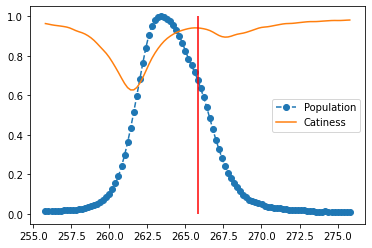

In [ ]:
plt.plot(Delta0grid,nss_listSIM/np.max(nss_listSIM),'o--',label='Population')
plt.plot(Delta0grid,catiness_listSIM,label='Catiness')
plt.vlines(x=Deltas,ymin=0,ymax=1,color='red')
plt.legend()
plt.show()

In [ ]:
kappa2

4.082131404031591

In [ ]:
Deltas

265.8022288340796

In [ ]:
delta2

10000

In [ ]:
# Simulation data (DO NOT TOUCH)
tfin = 2
#cutoff1=20
cutoff1=20
cutoff2 = 2
tlist=np.linspace(0,tfin,100)
a_red = destroy(cutoff1)
s = tensor(destroy(cutoff1), qeye(cutoff2))
shift = 10.
Delta0min = Deltas-shift; Delta0max = Deltas + shift; nDelta0 = 101
Delta0grid = np.linspace(Delta0min,Delta0max,nDelta0)

sol_list = [qload('data/sim1/sc-stabi-2drives-solution-idx-'+str(int(idx))+'.qu') for idx in range(nDelta0)]


In [ ]:
def catiness(rho,phase=0):

    cutoff = rho.shape[0]
    a_red = destroy(cutoff)
    a2 = expect(rho,a_red*a_red)
    alpha = np.sqrt(a2)
    cat = ket2dm((coherent(cutoff,alpha) +np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat_opposite = ket2dm((coherent(cutoff,alpha) -np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat = cat/np.trace(cat)
    cat_opposite = cat_opposite/np.trace(cat_opposite)
    overlap = abs(coherent(cutoff,alpha).overlap(coherent(cutoff,-alpha)))**2
    fid1=fidelity(cat,rho)
    rho2=(a_red*rho*a_red.dag())
    rho2 = rho2/np.trace(rho2)
    fid2 = fidelity(cat_opposite,rho2)


    return np.sqrt(fid1*fid2)


rho_sq_listSIM = [sol.final_state.ptrace(0) for sol in sol_list]
catiness_listSIM = [catiness(rho_sq) for rho_sq in rho_sq_listSIM]
wigner_listSIM = [wigner(rho_sq,xvec,xvec) for rho_sq in rho_sq_listSIM]
nss_listSIM = [expect(s.dag()*s,sol.final_state) for sol in sol_list]

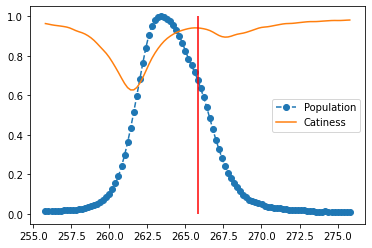

In [ ]:
plt.plot(Delta0grid,nss_listSIM/np.max(nss_listSIM),'o--',label='Population')
plt.plot(Delta0grid,catiness_listSIM,label='Catiness')
plt.vlines(x=Deltas,ymin=0,ymax=1,color='red')
plt.legend()
plt.show()

# Read cluster data: Simulation 2

In [9]:
Deltac = 1000
r=1
g = 1
kappa = 300


delta2 = 10000 # Detuning with respect to Delta_s
delta1 = 10000 # Detuning with respect to zero 


Omega2p = Deltac*(exp(4*r)-1)/(exp(4*r)+1)
Deltas=Deltac*np.sqrt(1-(Omega2p/Deltac)**2)

alpha1 = 1.5
alpha2 = 0.25

alpha0 = np.sqrt(Omega2p/4.)

alpha_list = [alpha1,alpha2]
shift = 0.
Delta_list = [Deltas-shift-delta2, Deltas-shift + delta2]

nalpha = len(alpha_list)
kappa2 = 4*(2*g*alpha1*np.cosh(r)**2)**2/kappa
G = 2*alpha1*alpha2*g*np.cosh(r)**2
na_expected = G/(kappa2)

na_expected, 1/kappa2, kappa2


tfin = 2
cutoff1=20
cutoff2 = 2
tlist=np.linspace(0,tfin,100)
a_red = destroy(cutoff1)
s = tensor(destroy(cutoff1), qeye(cutoff2))
shift = 10.
Delta0min = Deltas-shift; Delta0max = Deltas + shift; nDelta0 = 101
Delta0grid = np.linspace(Delta0min,Delta0max,nDelta0)

sol_list = [qload('data/sim2/sc-stabi-4drives-solution-idx-'+str(int(idx))+'.qu.qu') for idx in range(nDelta0)]


In [14]:
def catiness(rho,phase=0):

    cutoff = rho.shape[0]
    a_red = destroy(cutoff)
    a2 = expect(rho,a_red*a_red)
    alpha = np.sqrt(a2)
    cat = ket2dm((coherent(cutoff,alpha) +np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat_opposite = ket2dm((coherent(cutoff,alpha) -np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat = cat/np.trace(cat)
    cat_opposite = cat_opposite/np.trace(cat_opposite)
    overlap = abs(coherent(cutoff,alpha).overlap(coherent(cutoff,-alpha)))**2
    fid1=fidelity(cat,rho)
    rho2=(a_red*rho*a_red.dag())
    rho2 = rho2/np.trace(rho2)
    fid2 = fidelity(cat_opposite,rho2)


    return np.sqrt(fid1*fid2)

xvec = np.linspace(-5,5,100)
rho_sq_listSIM = [sol.final_state.ptrace(0) for sol in sol_list]
catiness_listSIM = [catiness(rho_sq) for rho_sq in rho_sq_listSIM]
wigner_listSIM = [wigner(rho_sq,xvec,xvec) for rho_sq in rho_sq_listSIM]
nss_listSIM = [expect(s.dag()*s,sol.final_state) for sol in sol_list]
nat_listSIM = np.array([sol.expect[0] for sol in sol_list])

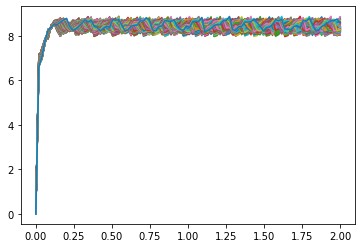

In [18]:
for nat in nat_listSIM:
    plt.plot(tlist,nat)
plt.show()

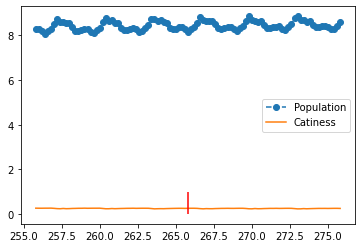

In [63]:
plt.plot(Delta0grid,nss_listSIM,'o--',label='Population')
plt.plot(Delta0grid,catiness_listSIM,label='Catiness')
plt.vlines(x=Deltas,ymin=0,ymax=1,color='red')
plt.legend()
plt.show()

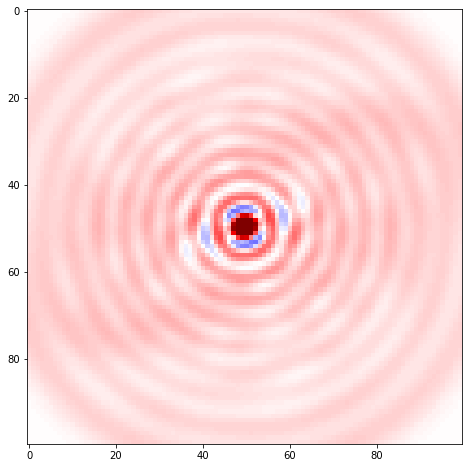

In [24]:
idx=4
nrm = mpl.colors.Normalize(-0.1, 0.1)
wig = wigner_listSIM[idx]
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(wig, cmap='seismic', norm=nrm)
plt.show()

# Read cluster data: Simulation 3

In [94]:
Deltac = 1000
r=1
g = 1
kappa = 300


delta2 = 10000 # Detuning with respect to Delta_s
delta1 = 20000 # Detuning with respect to zero 


Omega2p = Deltac*(exp(4*r)-1)/(exp(4*r)+1)
Deltas=Deltac*np.sqrt(1-(Omega2p/Deltac)**2)

alpha1 = 1.5
alpha2 = 0.25

alpha0 = np.sqrt(Omega2p/4.)

alpha_list = [alpha1,alpha2]
shift = 0.
Delta_list = [Deltas-shift-delta2, Deltas-shift + delta2]

nalpha = len(alpha_list)
kappa2 = 4*(2*g*alpha1*np.cosh(r)**2)**2/kappa
G = 2*alpha1*alpha2*g*np.cosh(r)**2
na_expected = G/(kappa2)

na_expected, 1/kappa2, kappa2


tfin = 2
cutoff1=20
cutoff2 = 2
tlist=np.linspace(0,tfin,100)
a_red = destroy(cutoff1)
s = tensor(destroy(cutoff1), qeye(cutoff2))
shift = 10.
Delta0min = Deltas-shift; Delta0max = Deltas + shift; nDelta0 = 101
Delta0grid = np.linspace(Delta0min,Delta0max,nDelta0)

sol_list = [qload('data/sim3/sc-stabi-4drives-solution-idx-'+str(int(idx))+'.qu.qu') for idx in range(nDelta0)]


In [95]:
def catiness(rho,phase=0):

    cutoff = rho.shape[0]
    a_red = destroy(cutoff)
    a2 = expect(rho,a_red*a_red)
    alpha = np.sqrt(a2)
    cat = ket2dm((coherent(cutoff,alpha) +np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat_opposite = ket2dm((coherent(cutoff,alpha) -np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat = cat/np.trace(cat)
    cat_opposite = cat_opposite/np.trace(cat_opposite)
    overlap = abs(coherent(cutoff,alpha).overlap(coherent(cutoff,-alpha)))**2
    fid1=fidelity(cat,rho)
    rho2=(a_red*rho*a_red.dag())
    rho2 = rho2/np.trace(rho2)
    fid2 = fidelity(cat_opposite,rho2)


    return np.sqrt(fid1*fid2)

xvec = np.linspace(-5,5,100)
rho_sq_listSIM = [sol.final_state.ptrace(0) for sol in sol_list]
catiness_listSIM = [catiness(rho_sq) for rho_sq in rho_sq_listSIM]
wigner_listSIM = [wigner(rho_sq,xvec,xvec) for rho_sq in rho_sq_listSIM]
nss_listSIM = [expect(s.dag()*s,sol.final_state) for sol in sol_list]
nat_listSIM = np.array([sol.expect[0] for sol in sol_list])

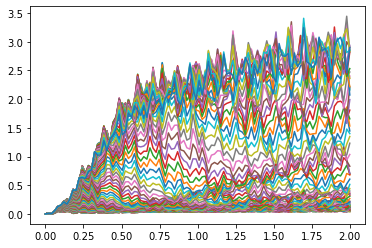

In [96]:
for nat in nat_listSIM:
    plt.plot(tlist,nat)
plt.show()

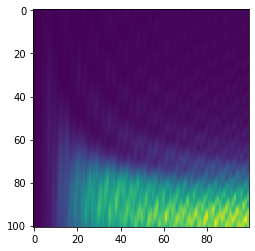

In [104]:
plt.imshow(nat_listSIM)
plt.show()

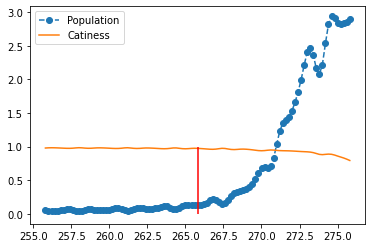

In [97]:
plt.plot(Delta0grid,nss_listSIM,'o--',label='Population')
plt.plot(Delta0grid,catiness_listSIM,label='Catiness')
plt.vlines(x=Deltas,ymin=0,ymax=1,color='red')
plt.legend()
plt.show()

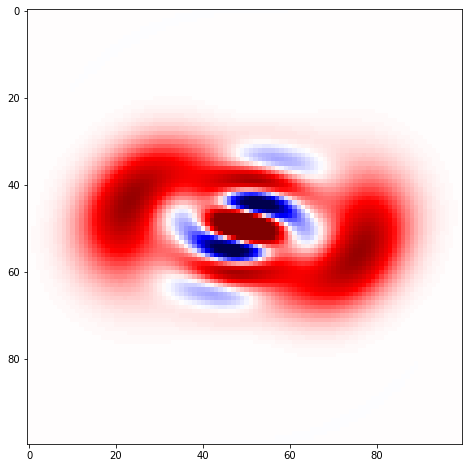

In [103]:
idx=100
nrm = mpl.colors.Normalize(-0.1, 0.1)
wig = wigner_listSIM[idx]
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(wig, cmap='seismic', norm=nrm)
plt.show()

# Read cluster data: Simulation 4

In [9]:
Deltac = 1000
r=1
g = 1
kappa = 300


delta2 = 10000 # Detuning with respect to Delta_s
delta1 = 20000 # Detuning with respect to zero 


Omega2p = Deltac*(exp(4*r)-1)/(exp(4*r)+1)
Deltas=Deltac*np.sqrt(1-(Omega2p/Deltac)**2)

alpha1 = 1.5
alpha2 = 0.25

alpha0 = np.sqrt(Omega2p/4.)

alpha_list = [alpha1,alpha2]
shift = 0.
Delta_list = [Deltas-shift-delta2, Deltas-shift + delta2]

nalpha = len(alpha_list)
kappa2 = 4*(2*g*alpha1*np.cosh(r)**2)**2/kappa
G = 2*alpha1*alpha2*g*np.cosh(r)**2
na_expected = G/(kappa2)

na_expected, 1/kappa2, kappa2


tfin = 2
cutoff1=20
cutoff2 = 2
tlist=np.linspace(0,tfin,100)
a_red = destroy(cutoff1)
s = tensor(destroy(cutoff1), qeye(cutoff2))
shift = 40.
Delta0min = Deltas; Delta0max = Deltas + shift; nDelta0 = 101
Delta0grid = np.linspace(Delta0min,Delta0max,nDelta0)

sol_list = [qload('data/sim4/sc-stabi-4drives-solution-idx-'+str(int(idx))+'.qu.qu') for idx in range(nDelta0)]


In [10]:
def catiness(rho,phase=0):

    cutoff = rho.shape[0]
    a_red = destroy(cutoff)
    a2 = expect(rho,a_red*a_red)
    alpha = np.sqrt(a2)
    cat = ket2dm((coherent(cutoff,alpha) +np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat_opposite = ket2dm((coherent(cutoff,alpha) -np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat = cat/np.trace(cat)
    cat_opposite = cat_opposite/np.trace(cat_opposite)
    overlap = abs(coherent(cutoff,alpha).overlap(coherent(cutoff,-alpha)))**2
    fid1=fidelity(cat,rho)
    rho2=(a_red*rho*a_red.dag())
    rho2 = rho2/np.trace(rho2)
    fid2 = fidelity(cat_opposite,rho2)


    return np.sqrt(fid1*fid2)

xvec = np.linspace(-5,5,100)
rho_sq_listSIM = [sol.final_state.ptrace(0) for sol in sol_list]
catiness_listSIM = [catiness(rho_sq) for rho_sq in rho_sq_listSIM]
wigner_listSIM = [wigner(rho_sq,xvec,xvec) for rho_sq in rho_sq_listSIM]
nss_listSIM = [expect(s.dag()*s,sol.final_state) for sol in sol_list]
nat_listSIM = np.array([sol.expect[0] for sol in sol_list])

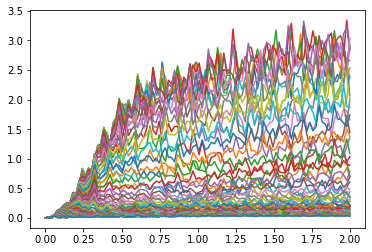

In [11]:
for nat in nat_listSIM:
    plt.plot(tlist,nat)
plt.show()

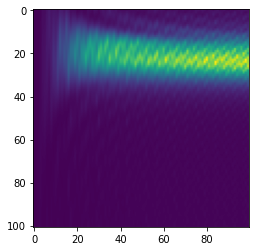

In [12]:
plt.imshow(nat_listSIM)
plt.show()

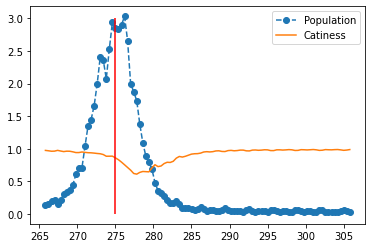

In [22]:
idx=23
plt.plot(Delta0grid,nss_listSIM,'o--',label='Population')
plt.plot(Delta0grid,catiness_listSIM,label='Catiness')
plt.vlines(x=Delta0grid[idx],ymin=0,ymax=3,color='red')
plt.legend()
plt.show()

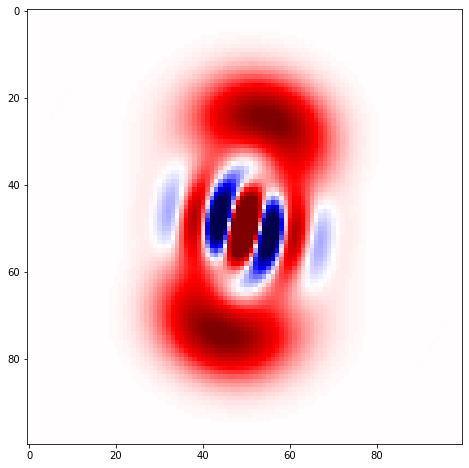

In [23]:
nrm = mpl.colors.Normalize(-0.1, 0.1)
wig = wigner_listSIM[idx]
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(wig, cmap='seismic', norm=nrm)
plt.show()

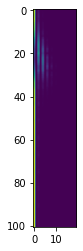

In [28]:
diagMatrix = np.array([np.diag(rho) for rho in rho_sq_listSIM])
plt.imshow(np.real(diagplots))
plt.show()

# Effective Simulation

In [153]:
shift = 10.
Delta0min = Deltas-shift; Delta0max = Deltas + shift; nDelta0 = 41
Delta0gridEff = np.linspace(Delta0min,Delta0max,nDelta0)
DeltaBiasGrid = Delta0gridEff-Deltas

In [164]:
sred = destroy(30)




kappa = 300
kappa2Old = 4*(2*g*alpha1*np.cosh(r)**2)**2/kappa

dem = kappa2Old*0.9
theta = 0.15*np.pi
U = dem*np.sin(theta)
kappa2Eff = dem*np.cos(theta)


H0 = U*sred.dag()*sred.dag()*sred*sred

def HDeltaBias(DeltaBias):
    H= [H0]
    H.append([G*sred.dag()*sred.dag(), H_exp_string(2*DeltaBias)])
    H.append([G*sred*sred, H_exp_string(-2*DeltaBias)])
    return H
    

psi0 = basis(cutoff1, 0)
tfin = 10
tlist=np.linspace(0,tfin,100)

c_ops = [np.sqrt(kappa2Eff)*sred*sred]

options = Options()
options.store_final_state = True
options.nsteps = 100000

In [165]:
sol_list = [mesolve(HDeltaBias(DeltaBias), psi0, tlist, c_ops, [sred.dag() * sred],options=options) for DeltaBias in tqdm(DeltaBiasGrid)]

100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


In [166]:
def catiness(rho,phase=0):

    cutoff = rho.shape[0]
    a_red = destroy(cutoff)
    a2 = expect(rho,a_red*a_red)
    alpha = np.sqrt(a2)
    cat = ket2dm((coherent(cutoff,alpha) +np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat_opposite = ket2dm((coherent(cutoff,alpha) -np.exp(1j*phase)*coherent(cutoff,-alpha)))
    cat = cat/np.trace(cat)
    cat_opposite = cat_opposite/np.trace(cat_opposite)
    overlap = abs(coherent(cutoff,alpha).overlap(coherent(cutoff,-alpha)))**2
    fid1=fidelity(cat,rho)
    rho2=(a_red*rho*a_red.dag())
    rho2 = rho2/np.trace(rho2)
    fid2 = fidelity(cat_opposite,rho2)


    return fid1*fid2*(1-overlap)

rho_sq_list = [sol.final_state for sol in sol_list]
catiness_list = [catiness(rho_sq) for rho_sq in rho_sq_list]
wigner_list = [wigner(rho_sq,xvec,xvec) for rho_sq in rho_sq_list]
nss_list = [expect(sred.dag()*sred,sol.final_state) for sol in sol_list]

In [167]:
rho_ss=sol.final_state
rho_sq = rho_ss.ptrace(0)

xvec = np.linspace(-5,5,100)
wigner_ss = wigner(rho_sq,xvec,xvec)

In [170]:
g*alpha1*np.cosh(r)**2

3.5716467683127235

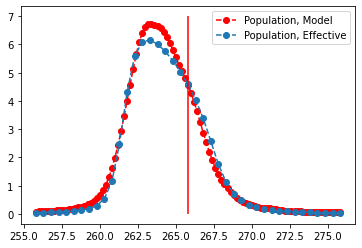

In [168]:
plt.plot(Delta0grid,nss_listSIM,'ro--',label='Population, Model')
plt.plot(Delta0gridEff,nss_list,'o--',label='Population, Effective')
plt.vlines(x=Deltas,ymin=0,ymax=7,color='red')
plt.legend()
plt.show()